
# Trabalho 2 — Unidade 2 (A* + MST)

Este projeto integra os conceitos de **busca heurística (A\*)** e **Árvore Geradora Mínima (MST)** aplicados à malha viária real de cidades brasileiras.  
O objetivo é **estimar a distância total mínima necessária para interligar pontos de interesse (POIs)** em cada cidade, utilizando dados do **OpenStreetMap** via **OSMnx** e algoritmos do **NetworkX**.

### Estrutura da Solução
1. **Modelagem do grafo viário** com OSMnx, incluindo projeção métrica e atributos de distância.
2. **Cálculo de rotas mais curtas** entre todos os POIs por meio do algoritmo **A\***, usando heurística geodésica (*great-circle*).
3. **Construção do grafo completo dos POIs**, onde cada aresta é ponderada pela distância obtida via A\*.
4. **Geração da MST (Kruskal)** para determinar o menor somatório de rotas que conecta todos os POIs.
5. **Visualização** das rotas reais sobre o mapa e **comparação entre oito capitais nordestinas**.


In [1]:

# Dependências
%pip -q install osmnx==1.9.3 networkx matplotlib pandas

import time
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import osmnx as ox

ox.settings.log_console = False
ox.settings.use_cache = True

print("Versões -> osmnx:", ox.__version__, "| networkx:", nx.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.2/107.2 kB 2.1 MB/s eta 0:00:00
Versões -> osmnx: 1.9.3 | networkx: 3.5


## A* (heurística geodésica)

In [2]:

def great_circle_heuristic(G, u, v):
    return ox.distance.great_circle(G.nodes[u]['y'], G.nodes[u]['x'],
                                    G.nodes[v]['y'], G.nodes[v]['x'])

def astar_path_length_by_length(G, source, target):
    return nx.astar_path_length(
        G, source, target,
        heuristic=lambda a, b: great_circle_heuristic(G, a, b),
        weight='length'
    )


## Modelagem da malha (OSMnx)

In [3]:

def build_city_graph(place: str, network_type: str = 'drive'):
    G = ox.graph_from_place(place, network_type=network_type)
    # Novo caminho recomendado (get_undirected é deprecated)
    G_undirected = ox.convert.to_undirected(G)
    # Garantir atributo length
    G_undirected = ox.distance.add_edge_lengths(G_undirected)
    return G, G_undirected


## Seleção de POIs

In [4]:

def get_poi_nodes(G_undirected, place: str, tags: dict, max_pois: int = 12):
    gdf = ox.geometries_from_place(place, tags)
    if gdf.empty:
        return []
    candidate_points = []
    for _, row in gdf.iterrows():
        geom = row.geometry
        if geom is None:
            continue
        pt = geom if geom.geom_type == "Point" else geom.centroid
        candidate_points.append((pt.y, pt.x))
    nodes = []
    for lat, lon in candidate_points[:max_pois*3]:
        try:
            # nearest_nodes espera (x, y) = (lon, lat)
            nid = ox.distance.nearest_nodes(G_undirected, lon, lat)
            nodes.append(nid)
        except Exception:
            pass
    seen, ordered = set(), []
    for n in nodes:
        if n not in seen:
            seen.add(n)
            ordered.append(n)
        if len(ordered) >= max_pois:
            break
    return ordered


## Grafo completo dos POIs (pesos = menor rota por A*)

In [5]:

def build_complete_graph_from_pois(G_undirected, poi_nodes):
    H = nx.Graph()
    H.add_nodes_from(poi_nodes)
    for i, u in enumerate(poi_nodes):
        for v in poi_nodes[i+1:]:
            try:
                d = astar_path_length_by_length(G_undirected, u, v)
            except Exception:
                d = nx.shortest_path_length(G_undirected, u, v, weight='length')
            H.add_edge(u, v, weight=float(d))
    return H


## MST (Kruskal) + reconstrução das rotas na malha

In [6]:

def compute_mst_edges(complete_graph: nx.Graph):
    return list(nx.minimum_spanning_edges(complete_graph, data=True))

def reconstruct_mst_routes_in_city(G_undirected, mst_edges):
    routes = []
    for (u, v, d) in mst_edges:
        route = nx.shortest_path(G_undirected, u, v, weight='length')
        routes.append(route)
    return routes


## Visualização

In [7]:

def plot_city_mst(G_undirected, poi_nodes, mst_routes, title="MST entre POIs"):
    fig, ax = ox.plot_graph(G_undirected, node_size=0, edge_color="lightgray",
                            edge_linewidth=0.5, show=False, close=False)
    for route in mst_routes:
        xs = [G_undirected.nodes[n]['x'] for n in route]
        ys = [G_undirected.nodes[n]['y'] for n in route]
        ax.plot(xs, ys, linewidth=2.0, zorder=3)
    xs = [G_undirected.nodes[n]['x'] for n in poi_nodes]
    ys = [G_undirected.nodes[n]['y'] for n in poi_nodes]
    ax.scatter(xs, ys, s=60, c="black", zorder=4)
    ax.set_title(title)
    plt.show()


## Pipeline por cidade

In [8]:

def run_city_pipeline(place: str, poi_tags: dict, max_pois: int = 10, plot: bool = True):
    G, G_u = build_city_graph(place)
    poi_nodes = get_poi_nodes(G_u, place, poi_tags, max_pois=max_pois)
    if len(poi_nodes) < 2:
        return {
            "place": place, "n_pois": len(poi_nodes), "mst_total_length_m": float("nan"),
            "status": "POIs insuficientes", "poi_nodes": poi_nodes, "G_u": G_u, "G": G, "mst_routes": []
        }
    H = build_complete_graph_from_pois(G_u, poi_nodes)
    mst_edges = compute_mst_edges(H)
    total = sum(d['weight'] for (_,_,d) in mst_edges)
    routes = reconstruct_mst_routes_in_city(G_u, mst_edges)
    if plot:
        plot_city_mst(G_u, poi_nodes, routes, title=f"MST entre POIs em {place}")
    return {
        "place": place, "n_pois": len(poi_nodes), "mst_total_length_m": float(total),
        "status": "ok", "poi_nodes": poi_nodes, "G_u": G_u, "G": G, "mst_routes": routes
    }


## Comparação entre ≥ 8 cidades

In [9]:

cities = [
    "Natal, Rio Grande do Norte, Brazil",
    "João Pessoa, Paraíba, Brazil",
    "Recife, Pernambuco, Brazil",
    "Maceió, Alagoas, Brazil",
    "Fortaleza, Ceará, Brazil",
    "Teresina, Piauí, Brazil",
    "São Luís, Maranhão, Brazil",
    "Aracaju, Sergipe, Brazil"
]
poi_tags = {"amenity": "hospital"}

results = []
for place in cities:
    t0 = time.time()
    try:
        out = run_city_pipeline(place, poi_tags=poi_tags, max_pois=10, plot=False)
    except Exception as e:
        out = {"place": place, "n_pois": 0, "mst_total_length_m": float("nan"),
               "status": f"erro: {e}"}
    out["elapsed_s"] = time.time() - t0
    results.append(out)

import pandas as pd
df = pd.DataFrame([{"Cidade": r.get("place"),
                    "POIs": r.get("n_pois", 0),
                    "MST_total_m": r.get("mst_total_length_m", float("nan")),
                    "Status": r.get("status", ""),
                    "Tempo_s": r.get("elapsed_s", float("nan"))
                   } for r in results])
df.sort_values("MST_total_m", inplace=True, na_position="last")
df.reset_index(drop=True, inplace=True)
df


/tmp/ipython-input-3984745316.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_place(place, tags)
/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyt

,Cidade,POIs,MST_total_m,Status,Tempo_s
0,"Aracaju, Sergipe, Brazil",10,10774.997,ok,23.919556
1,"Fortaleza, Ceará, Brazil",10,17648.124,ok,71.229929
2,"Natal, Rio Grande do Norte, Brazil",10,20535.259,ok,33.854930
3,"João Pessoa, Paraíba, Brazil",10,20746.817,ok,29.705169
4,"São Luís, Maranhão, Brazil",10,21309.475,ok,50.631498
5,"Teresina, Piauí, Brazil",10,23163.823,ok,55.496882
6,"Maceió, Alagoas, Brazil",10,25816.122,ok,31.141831
7,"Recife, Pernambuco, Brazil",10,30893.052,ok,56.832039


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## Exemplos de visualização

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3984745316.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module an

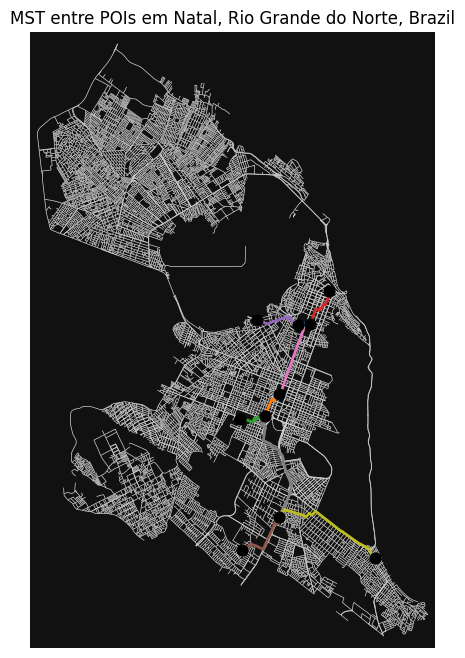

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [10]:

city_to_plot = "Natal, Rio Grande do Norte, Brazil"
poi_tags = {"amenity": "hospital"}
_ = run_city_pipeline(city_to_plot, poi_tags=poi_tags, max_pois=10, plot=True)


/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3984745316.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module an

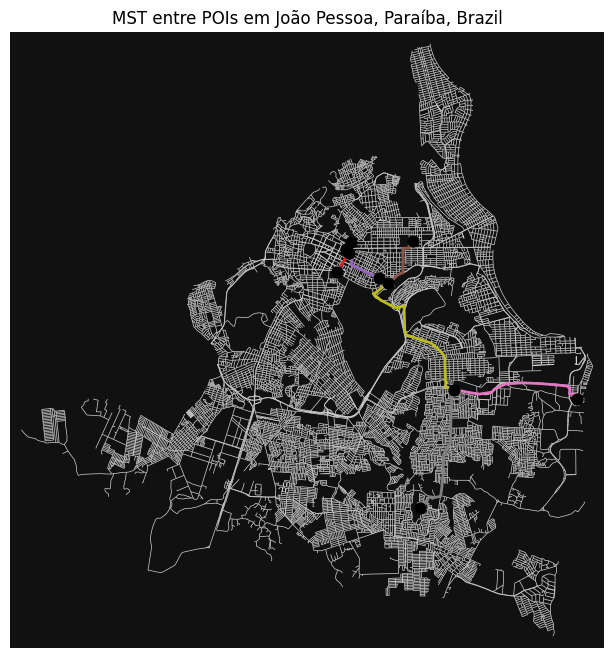

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [11]:

city_to_plot = "João Pessoa, Paraíba, Brazil"
poi_tags = {"amenity": "hospital"}
_ = run_city_pipeline(city_to_plot, poi_tags=poi_tags, max_pois=10, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3984745316.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module an

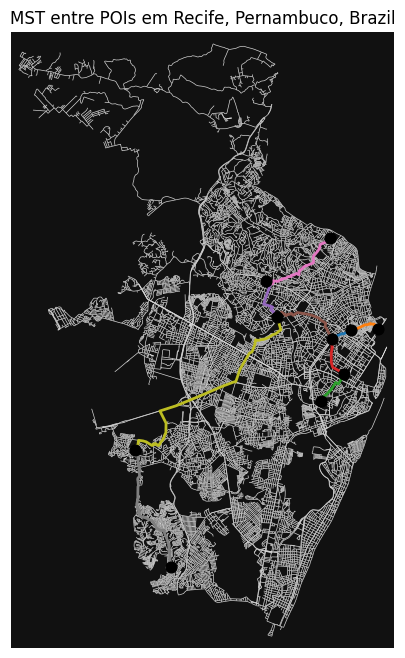

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [12]:

city_to_plot = "Recife, Pernambuco, Brazil"
poi_tags = {"amenity": "hospital"}
_ = run_city_pipeline(city_to_plot, poi_tags=poi_tags, max_pois=10, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3984745316.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_place(place, tags)
/usr/local/lib/python3.12/dist-packages/osmnx

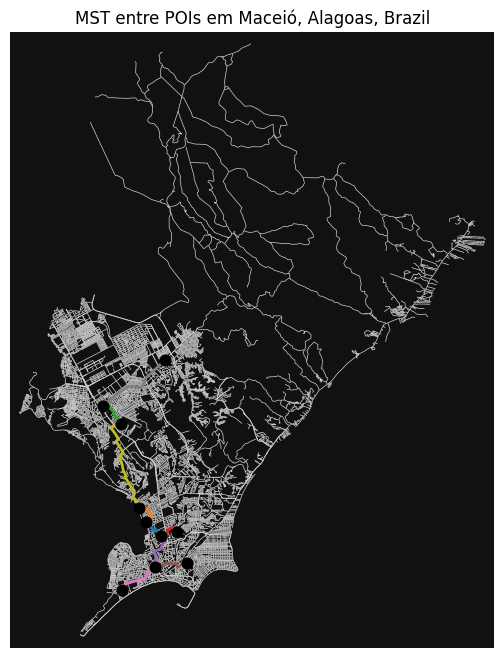

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [13]:

city_to_plot = "Maceió, Alagoas, Brazil"
poi_tags = {"amenity": "hospital"}
_ = run_city_pipeline(city_to_plot, poi_tags=poi_tags, max_pois=10, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3984745316.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_place(place, tags)
/usr/local/lib/python3.12/dist-packages/osmnx

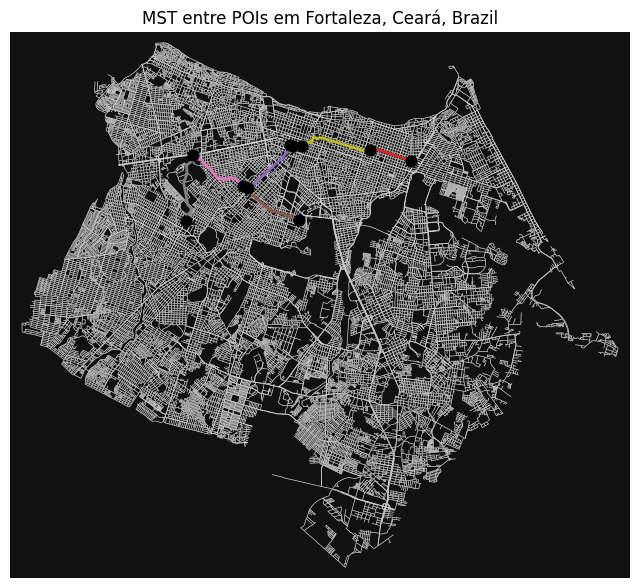

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [14]:

city_to_plot = "Fortaleza, Ceará, Brazil"
poi_tags = {"amenity": "hospital"}
_ = run_city_pipeline(city_to_plot, poi_tags=poi_tags, max_pois=10, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3984745316.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_place(place, tags)
/usr/local/lib/python3.12/dist-packages/osmnx

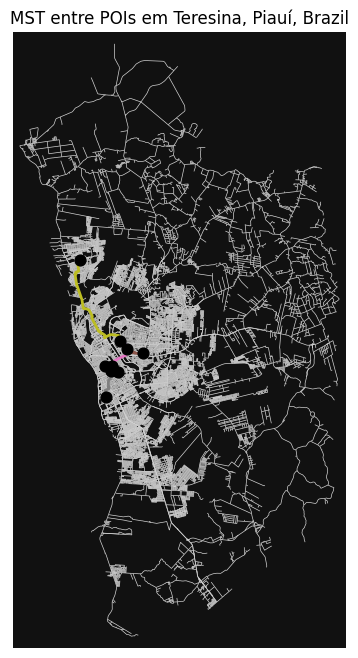

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:

city_to_plot = "Teresina, Piauí, Brazil"
poi_tags = {"amenity": "hospital"}
_ = run_city_pipeline(city_to_plot, poi_tags=poi_tags, max_pois=10, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3984745316.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_place(place, tags)
/usr/local/lib/python3.12/dist-packages/osmnx

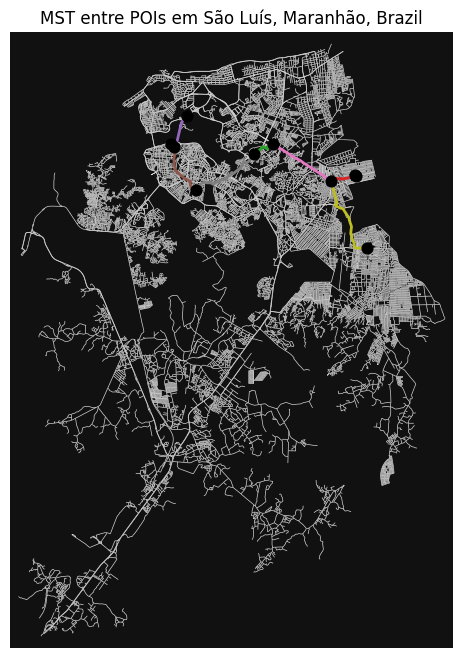

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:

city_to_plot = "São Luís, Maranhão, Brazil"
poi_tags = {"amenity": "hospital"}
_ = run_city_pipeline(city_to_plot, poi_tags=poi_tags, max_pois=10, plot=True)

/usr/local/lib/python3.12/dist-packages/osmnx/graph.py:392: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-3984745316.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries_from_place(place, tags)
/usr/local/lib/python3.12/dist-packages/osmnx

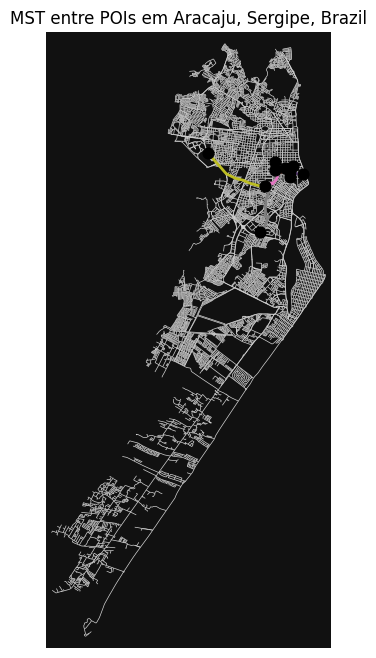

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:

city_to_plot = "Aracaju, Sergipe, Brazil"
poi_tags = {"amenity": "hospital"}
_ = run_city_pipeline(city_to_plot, poi_tags=poi_tags, max_pois=10, plot=True)